### Import modules

In [1]:
import sys
import os
from numpy import array
from pandas import read_csv, DataFrame, Series, Index, Period
from matplotlib.pyplot import subplots, figure, show, plot, legend
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.tsa.stattools import adfuller

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import plot_line_chart, HEIGHT, set_chart_labels, plot_multiline_chart


### Load data

In [2]:
data_path = os.path.abspath(os.path.join('..','..', 'data/f_e_forecast_gdp_europe.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Year",
        sep=",",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)

data.head()

,Birth_rate,CO2_emissions,Death_rate,Electric_power_consumption,Energy_use,Food_exports,Food_imports,Goods_services_exports,Goods_services_imports,Population_density,GDP
Year,,,,,,,,,,,
1960-01-01,18.580,5.762,10.233,1427.783,1720.317,NaN,NaN,NaN,NaN,NaN,359.029
1961-01-01,18.534,5.922,10.114,1523.150,1761.406,NaN,NaN,6.007,6.128,98.077,390.887
1962-01-01,18.337,6.209,10.441,1641.966,1869.038,17.703,23.804,5.810,7.448,98.948,427.015
1963-01-01,18.415,6.574,10.381,1758.415,1979.026,15.114,21.275,6.198,10.371,99.831,470.415
1964-01-01,18.510,6.790,10.051,1884.315,2045.755,14.513,19.838,9.225,9.728,100.706,521.328


### Plot data

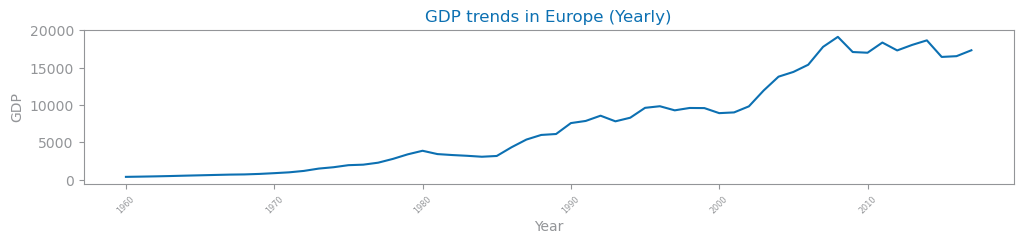

Nr. Records =  (58, 11)
First timestamp 1960-01-01 00:00:00
Last timestamp 2017-01-01 00:00:00


In [3]:
file_tag = "GDP trends in Europe (Yearly)"
target = "GDP"
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag}",
)
show()

print("Nr. Records = ", data.shape)
print("First timestamp", data.index[0])
print("Last timestamp", data.index[-1])

### Distribution

Text(0.2, 0, 'count       58.000000\nmean      7426.495552\nstd       6310.412525\nmin        359.029000\n25%       1720.540750\n50%       6044.174000\n75%      11420.337250\nmax      19137.007000\nName: GDP, dtype: float64')

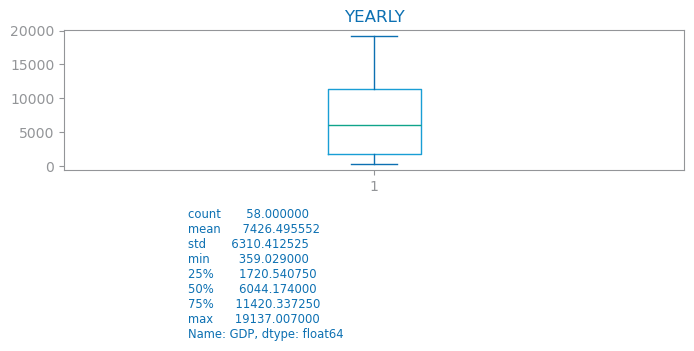

In [4]:
fig: Figure
axs: array
fig, axs = subplots(2, 1, figsize=(2 * HEIGHT, HEIGHT))
set_chart_labels(axs[0], title="YEARLY")
axs[0].boxplot(series)


axs[1].grid(False)
axs[1].set_axis_off()
axs[1].text(0.2, 0, str(series.describe()), fontsize="small")


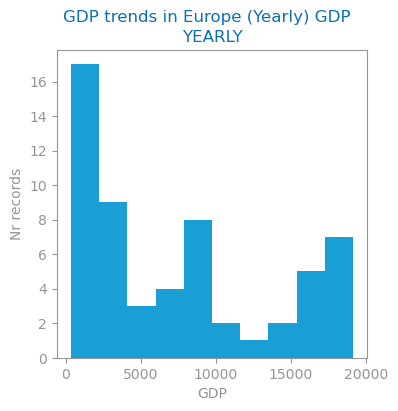

In [5]:
grans: list[Series] = [series]
gran_names: list[str] = ["YEARLY"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
axs = [axs]
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
show()

<Axes: xlabel='Data', ylabel='GDP'>

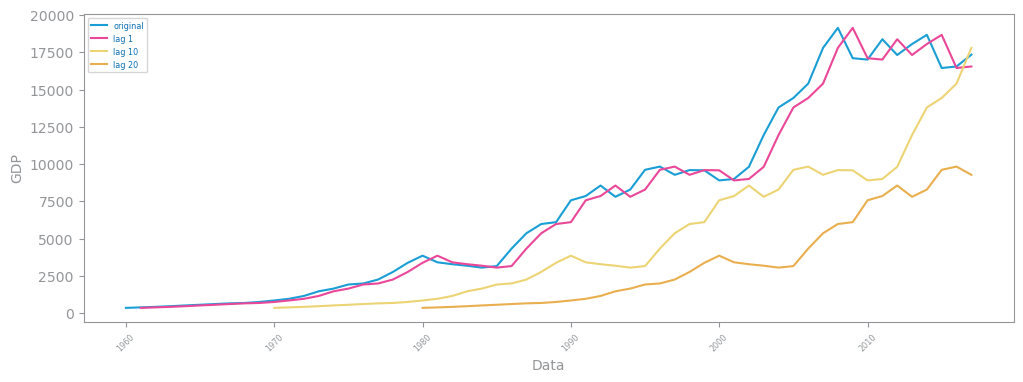

In [6]:
def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel="Data", ylabel=target)

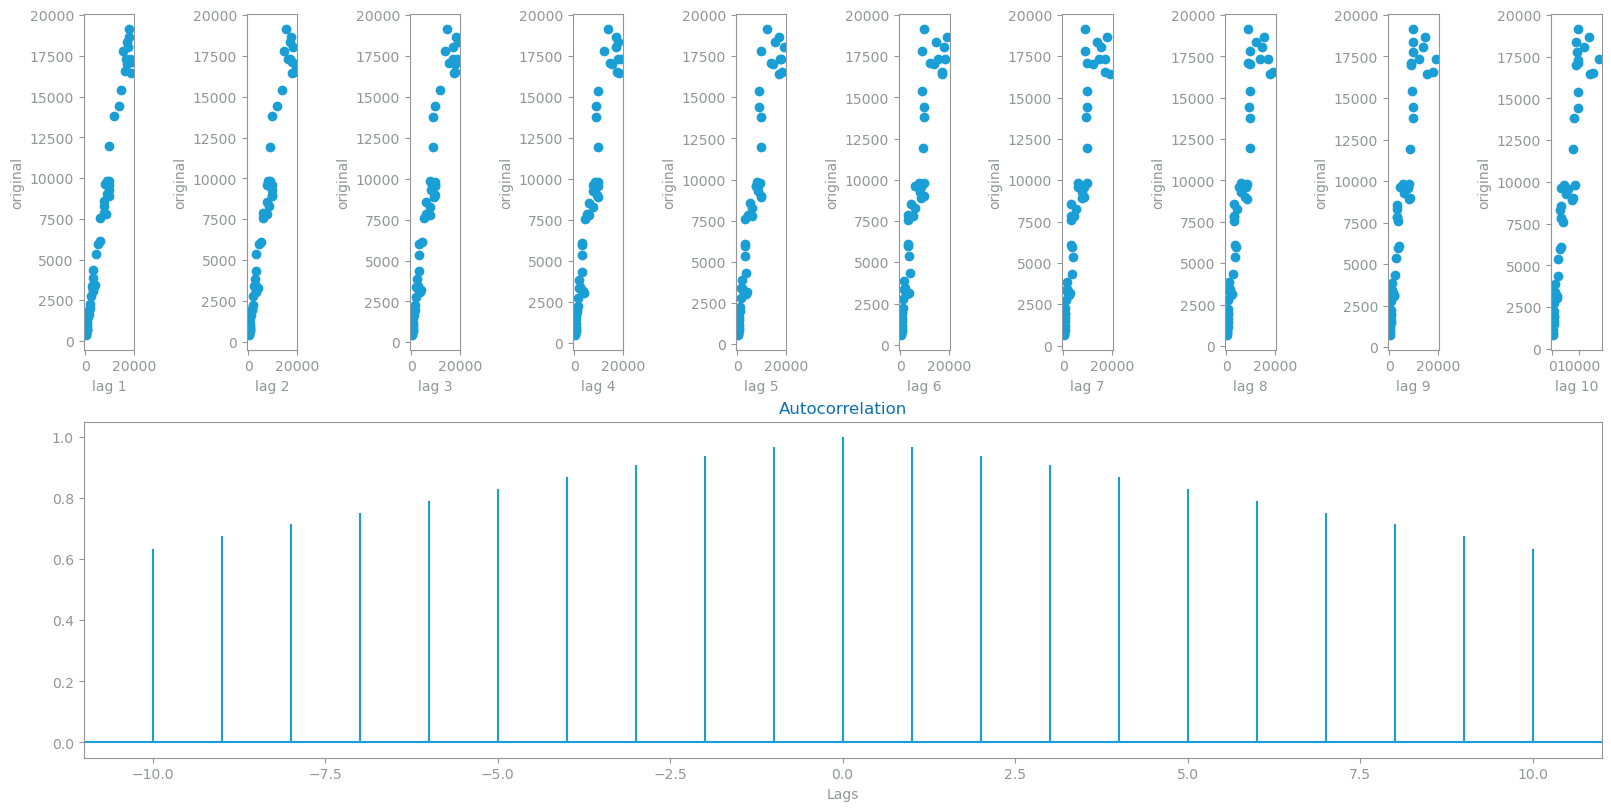

In [7]:
def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)

### Stationarity

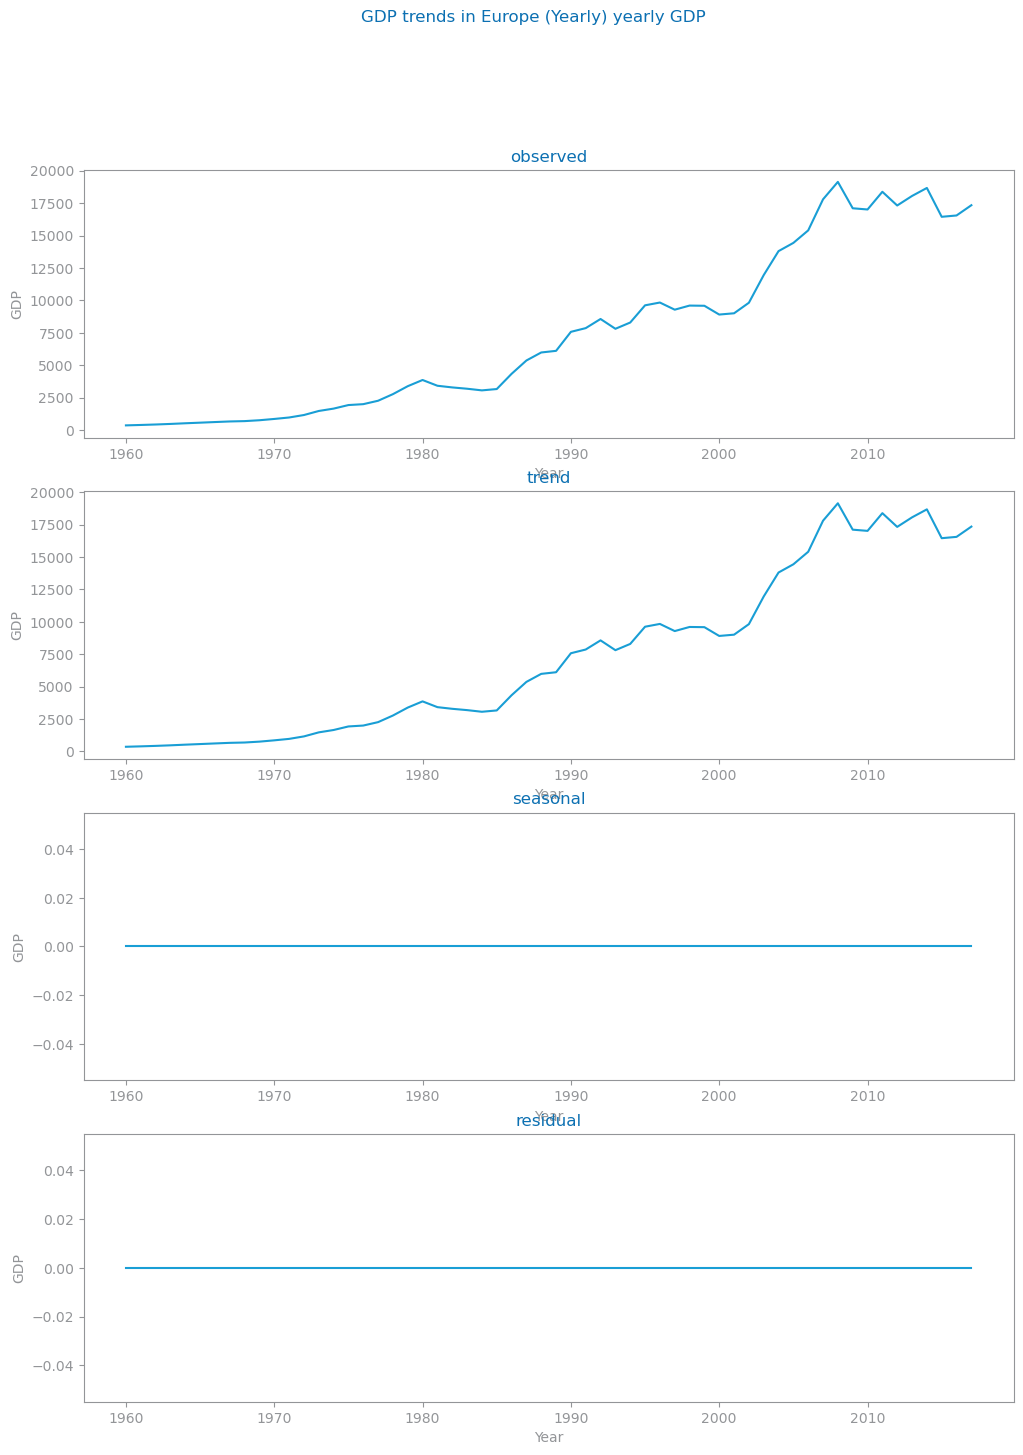

In [8]:
def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs

plot_components(
    series,
    title=f"{file_tag} yearly {target}",
    x_label=series.index.name,
    y_label=target,
)
show()


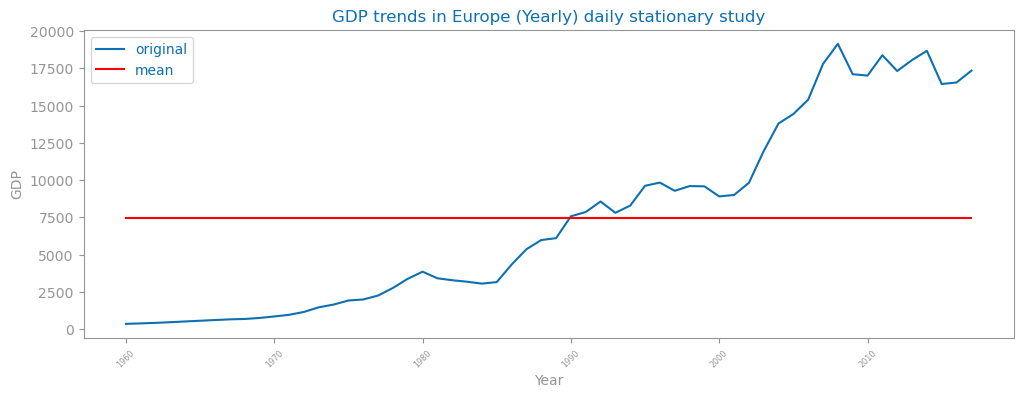

In [9]:
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} daily stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
show()


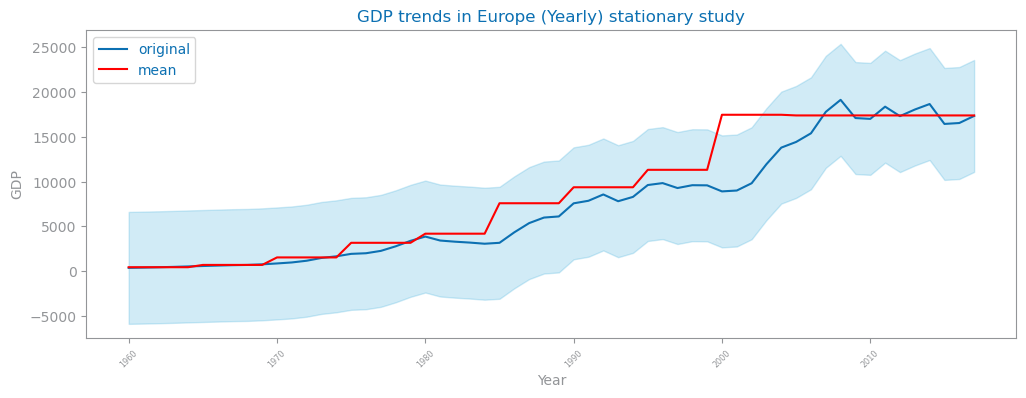

In [10]:
def plot_stationary_study(series):
    BINS = 10
    mean_line: list[float] = []
    n: int = len(series)

    for i in range(BINS):
        segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
        mean_value: list[float] = [segment.mean()] * (n // BINS)
        mean_line += mean_value
    mean_line += [mean_line[-1]] * (n - len(mean_line))

    figure(figsize=(3 * HEIGHT, HEIGHT))
    plot_line_chart(
        series.index.to_list(),
        series.to_list(),
        xlabel=series.index.name,
        ylabel=target,
        title=f"{file_tag} stationary study",
        name="original",
        show_stdev=True,
    )
    n: int = len(series)
    plot(series.index, mean_line, "r-", label="mean")
    legend()
    show()

plot_stationary_study(series)


In [11]:
def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -0.608
p-value: 0.869
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596
The series is not stationary
